### Importing required libaries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from models.old_model import SiameseNetwork

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine

from utils.vis_utils import imshow, show_plot
from utils.other_utils import joinpath, SiameseNetworkDataset, SiameseNetworkDataset_for_test, get_dataset
from utils.other_utils import intersection


In [3]:
# Setup the path where images are located
PATH = r"/Users/paligonshik/Desktop/Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning/data/faces"


# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=1

# no of epoch
EPOCH = 25

It will read two images and return them, as well as their label. 
If they are in the same category, i.e. the same person, 
it will return 0, and otherwise, it will return 1.

It will read one image at a time and return its label based on the folder it is present

Initialize the dataset by calling the ImageFolderfunction and passing the path to the training set. 
Define a simple transformation of only a resize and transformation to tensors. 
Call  custom class and pass in the transformation, as well as the folder_dataset created at the top

In [4]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])




# transformation_for_test = transforms.Compose([transforms.Resize((100,100)),
                                              
#                                      transforms.RandomApply(transforms.RandomRotation([-180,180]), p= 0.5),


#                                      transforms.ToTensor()])

transformation_for_test = transforms.Compose([transforms.Resize((100,100)),
    transforms.ToTensor(), 
    transforms.RandomApply([
         transforms.RandomRotation([-180,180])], p = 0.6)
])

For simple visualization purposes let’s look at this example.  
Create a DataLoader of the siamese_dataset and extract the first batch only.  
Combine each combination of images, because our siamese_datasetwill return two images and one label, and print out the labels.

In [5]:
os.cpu_count() #cpu count

10

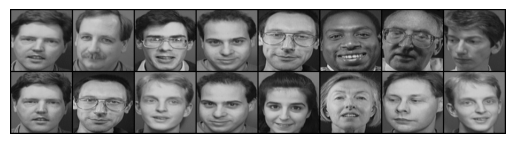

[0. 1. 1. 0. 1. 1. 1. 1.]


In [6]:
# Create a simple dataloader just for simple visualization
# vis_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=0, # Number of CPU to engage
#                         batch_size=8)

vis_dataloader,_ = get_dataset(joinpath(PATH,'train'),transformation,SiameseNetworkDataset,0,8,True)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

### Contrastive Loss Function
How do we calculate the distance or the dissimilarity between these two vectors?

Let’s look at an example when both \(x^{(i)}\) and \(x^{(j)}\) are of the same person, I will denote these two images as \(A\) and \(B\). In this case, we want \(d\) to be a small value:

\(d(A, B) = ||f(A) – f(B)||^2\)

But, what happens when \(x^{(i)}\) and \(x^{(j)}\) are of different people, or a negative pair? Then the distance \(d\) should be large. In such a case, we will not apply the l2 distance norm, or distance function directly, but rather a hinge loss. Why is that?

We want to separate \(f(x^{(i)})\) and \(f(x^{(j)})\) if they are of different people, but we want to separate them until we hit a certain margin \(m\). The idea behind this, is that we don’t actually want to push \(f(x^{(i)})\) and \(f(x^{(j)})\) further and further apart if they are already far from the margin \(m\).

\(d(A, B) = max(0, m^2 – ||f(A) – f(B)||^2)\)

Now, we combine the two together and end up with a formula that is called the Contrastive Loss Function.

This function will calculate the similarity between the two vectors. As we mentioned earlier, the objective of the Siamese networks is not to classify, but rather to differentiate between the images. So a loss function like Cross-Entropy loss is not suitable for this problem.

The Contrastive Loss function evaluates how well the network distinguishes a given pair of images. The function is defined as follows:

\(L(A, B, Y) = (Y)*||f(A) – f(B)||^2 + (1-Y)*\{ max(0, m^2 – ||f(A) – f(B)||^2)\}\)

Looking at the equation at the top, \(Y\) here indicates the label. The label will be 1 if the two images are of the same person, and 0 if the images are of different persons.

The equation has two parts. One positive part, when the two images are of the same people, and one negative part, when the two images are of different people.

From left to right, the first part of the formula is the positive pair, we know when the two images are of the same person, our \(Y\) will be 1. We want to minimize the distance between these two embeddings when the two images are of the same person. So the first part of the equation will be used, but the second part will be ignored because \((1-Y)\) will equal to \(0\).

When we actually have a negative pair, \(Y\) is equal to 0, the left part is ignored and the second part is used. Here we apply the hinge loss, because of the reason mentioned above, and we separate our embeddings further and further away until we hit the margin \(M\).

The output of this equation will be the value that will indicate if the two images are of the same person or not, the same category or not.

This loss function is so to say, the most basic function for learning similarity. Still, even being the most basic, it can solve most of the similarity problems. 


Now that we defined the loss function that we will use, our next step would be definining the data that we will use for the training, and create a data loader object. It will accept our siamese_datasetand also shuffle our data. We will set the num_workersto 8 and also the batch_size to 64.

We will also initialize our model, as well as the loss and optimizer.

In [7]:
# Load the training dataset
# train_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=0,
#                         batch_size=64)

train_dataloader,_ = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset, 0, 64, True)
net = SiameseNetwork(nchannel)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [8]:
print(net)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)


In [9]:
from torchsummary import summary
# summary(net, [(3, 100, 100), (3, 100, 100)])
summary(net, [(nchannel, 100, 100), (nchannel, 100, 100)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 23, 23]          11,712
              ReLU-2           [-1, 96, 23, 23]               0
         MaxPool2d-3           [-1, 96, 11, 11]               0
            Conv2d-4            [-1, 256, 7, 7]         614,656
              ReLU-5            [-1, 256, 7, 7]               0
         MaxPool2d-6            [-1, 256, 3, 3]               0
            Conv2d-7            [-1, 384, 1, 1]         885,120
              ReLU-8            [-1, 384, 1, 1]               0
            Linear-9                 [-1, 1024]         394,240
             ReLU-10                 [-1, 1024]               0
           Linear-11                  [-1, 256]         262,400
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
           Conv2d-14           [-1, 96,

Following the flow diagram from the top, we can start creating the training loop. We iterate 200 times and extract the two images as well as the label. We zero the gradients and pass our two images into the network, and the network outputs two vectors. The two vectors, and the label, are then fed into the criterion (loss function) that we defined. We backpropagate and optimize. For some visualization purposes and to see how our model is performing on the training set, so we will print the loss every 10 batches.

In [10]:
def train(epochs = EPOCH):

    counter = []
    loss_history = [] 
    iteration_number= 0

    # Iterate throught the epochs
    for epoch in range(epochs):

    # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0, img1, label

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches print out the loss
            if i % 10 == 0 :
                print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return (counter,loss_history)

In [12]:
counter,loss_history = train(5)


Epoch number 0
 Current loss 0.03991716727614403

Epoch number 1
 Current loss 0.06275997310876846

Epoch number 2
 Current loss 0.05675539746880531

Epoch number 3
 Current loss 0.01888497918844223

Epoch number 4
 Current loss 0.02575288712978363



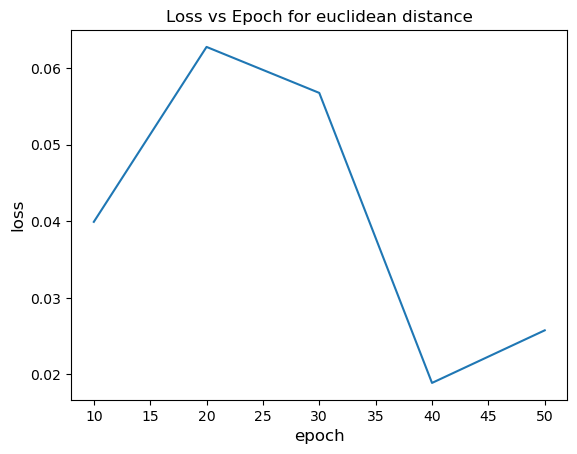

In [13]:

plt.figure()
plt.title('Loss vs Epoch for euclidean distance')
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
show_plot(counter, loss_history)

We can now analyze the results. The first thing we can see is that the loss started around 1.6 and ended at a number pretty close to 0.

It would be interesting to see the model in action. Now comes the part where we test our model on images it didn’t see before. As we have done before, we create a Siamese Network Dataset using our custom dataset class, but now we point it to the test folder.

As the next steps, we extract the first image from the first batch of the test set and iterate over all the train images to check how it performs.

We pass in the two images into the model and obtain two vectors, which are then passed into theF.pairwise_distance() function, this will calculate the euclidean distance between the two vectors. Using this distance, we can as a metric of how dissimilar the two faces are.

In [14]:
# def get_dataset(path,transforms,SiameseNetworkDataset,batch_size,shuffle):
#     folder_dataset = datasets.ImageFolder(root=path)
#     siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
#                                             transform=transforms)
#     dataloader = DataLoader(siamese_dataset, batch_size=batch_size, shuffle=shuffle)
#     return dataloader

In [15]:
# #### here we create dataiter for test

# # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
# test_dataloader,_ = get_dataset(joinpath(PATH,'test'), transformation_for_test, SiameseNetworkDataset_for_test, 0, 1, True)

# # Grab one image that we are going to test
# dataiter = iter(test_dataloader)
# x0,_ = next(dataiter)


# #### here we create dataiter for train.

# # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
# train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)

# dataiter_train = iter(train_dataloader)

# score = []

# for i in range(len(siamese_dataset_train)):
#     # Iterate over all images and test them with the first image (x0)
#     x1,_ = next(dataiter_train)

#     # Concatenate the two images together
#     concatenated = torch.cat((x0, x1), 0)
    
#     output1, output2 = net(x0, x1)
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     score.append(round(euclidean_distance.item(),2))
#     imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
#     # cosine_distance = torch.cosine_similarity(output1, output2)
#     # score.append(round(cosine_distance.item(),2))
#     # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {cosine_distance.item():.2f}')

Now we test all the test images with all the train images and all combination are unique.

In [16]:

# import time

# start_time = time.time()

# test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)
# #### here we create dataiter for train


# train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)


# truth=[]
# predict=[]
# same_disssimilarity=[]
# different_disssimilarity=[]
# count_label0 = []
# count_label1 = []


# dataiter = iter(test_dataloader)
# for i in range(len(siamese_dataset)):
    
#     x0,label0 = next(dataiter)
#     count_label0.append(label0)
    

# # Grab one image that we are going to test
#     dataiter_train = iter(train_dataloader)

#     for i in range(len(siamese_dataset_train)):
#     # Iterate over 5 images and test them with the first image (x0)
#         x1,label1 = next(dataiter_train)
#         count_label1.append(label1)

#         # Concatenate the two images together
#         concatenated = torch.cat((x0, x1), 0)

#         output1, output2 = net(x0, x1)
#         euclidean_distance = F.pairwise_distance(output1, output2)
        

#         predict.append(euclidean_distance.item())
#         if label0==label1: # if labels of two images are same append them to same_dissimilar
#             same_disssimilarity.append(euclidean_distance.item())
#         else:
#             different_disssimilarity.append(euclidean_distance.item())

#         # cosine_distance = torch.cosine_similarity(output1, output2)
#         # predict.append(cosine_distance.item())
#         # if label0==label1:
#         #     same_disssimilarity.append(cosine_distance.item())
#         # else:
#         #     different_disssimilarity.append(cosine_distance.item())


# # checking if there are any intersection in same and different images

# end_time = time.time()

# execution_time = end_time - start_time

# print("Execution time: ", execution_time, " seconds")

# intersection = []

# for i in same_disssimilarity:
#   if i > min(different_disssimilarity):
#     intersection.append(i)
# for j in different_disssimilarity:
#   if j < max(same_disssimilarity):
#     intersection.append(j)

# print("Number of total interesection: ", len(intersection))

In [17]:
# # Checking for number of missclassified images

# final_list = []
# same_misclassified = []
# different_misclassified = []
# score = 0.3
# for s in same_disssimilarity:
#     if s > score:
#         final_list.append(s)
#         same_misclassified.append(s)
# for d in different_disssimilarity:
#     if d <= score:
#         final_list.append(d)
#         different_misclassified.append(d)

# print(len(final_list))
# print(len(same_misclassified))
# print(len(different_misclassified))

In [18]:
from collections import defaultdict
dct_embeddings = defaultdict(list)


In [19]:
loader_embed,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)

dataiter_train = iter(loader_embed)



In [20]:
for i in range(len(siamese_dataset_train)):
    tensor_img,class_name =next(dataiter_train)
    class_name = class_name[0]
    dct_embeddings[class_name].append(net.forward_once(tensor_img))

In [21]:
mean_dict = {}
for key in dct_embeddings:
    mean_tensor = torch.mean(torch.stack(dct_embeddings[key]), dim=0)
    mean_dict[key] = mean_tensor

# Print the resulting mean dictionary
print(mean_dict)

{'s1': tensor([[-1.0845,  2.6046, -1.8076,  1.4792,  0.3891, -2.8278,  0.3163, -1.5113,
          1.7543,  3.1880, -1.4880,  0.2357,  2.1821,  0.7604, -0.8040,  1.8854,
         -0.3728,  1.0120, -0.6299, -2.0565,  0.6166, -1.1620,  0.1373, -3.1134,
         -2.3607,  1.0114,  2.6243,  0.0430,  1.1594, -1.2313,  0.3363, -2.1115,
         -0.0958,  2.5431, -0.7675, -2.5629,  2.3410,  0.4208, -1.6915,  0.9714,
          0.0376,  1.5484, -0.0635, -4.1549,  1.3489,  2.1777,  1.0440,  1.4054,
         -1.7855, -0.3974,  0.3697, -0.9487,  2.0535, -0.6920,  0.5243, -0.9522,
          1.1668, -0.2951, -0.3647, -1.7596,  0.0637, -0.5588,  1.7064, -0.0190,
         -0.1375, -1.6350,  1.8418, -2.8901,  2.4051, -1.0778, -0.1871,  0.1370,
          3.7022,  1.9402,  1.6377, -1.8237,  0.1554,  2.1158,  1.2720,  0.4845,
         -1.3199, -0.4297, -0.2309,  2.8547,  1.8809,  2.3147,  1.0344, -3.0782,
         -1.8128,  2.2156,  1.1730,  2.6432,  1.2089, -0.2844, -1.1608,  2.3308,
         -0.4862,  0.

In [22]:

import time

start_time = time.time()

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)
#### here we create dataiter for train


truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]
count_label0 = []
count_label1 = []


dataiter = iter(test_dataloader)
for i in range(len(siamese_dataset)):
    
    x0,label0 = next(dataiter)
    label0 = label0[0]
    count_label0.append(label0)
    


    for key,value in mean_dict.items():
    # Iterate over 5 images and test them with the first image (x0)
        output2,label1 =value,key
        count_label1.append(label1)



        output1 = net.forward_once(x0)
        euclidean_distance = F.pairwise_distance(output1, output2)
        

        predict.append(euclidean_distance.item())
        if label0==label1: # if labels of two images are same append them to same_dissimilar
            same_disssimilarity.append(euclidean_distance.item())
        else:
            different_disssimilarity.append(euclidean_distance.item())

end_time = time.time()

execution_time = end_time - start_time

print("Execution time: ", execution_time, " seconds")

intersection = []

for i in same_disssimilarity:
  if i > min(different_disssimilarity):
    intersection.append(i)
for j in different_disssimilarity:
  if j < max(same_disssimilarity):
    intersection.append(j)

print("Number of total interesection: ", len(intersection))

Execution time:  2.685215950012207  seconds
Number of total interesection:  28


In [23]:
# Checking for number of missclassified images

final_list = []
same_misclassified = []
different_misclassified = []
score = 0.3
for s in same_disssimilarity:
    if s > score:
        final_list.append(s)
        same_misclassified.append(s)
for d in different_disssimilarity:
    if d <= score:
        final_list.append(d)
        different_misclassified.append(d)

print(len(final_list))
print(len(same_misclassified))
print(len(different_misclassified))

6
0
6


In [24]:
def n_way_shot_leearning(image_input,embedding_dict,threshold):
    """
    @embedding dict is a dictionary where keys are labels values are prototypes
    """
    output1 = net.forward_once(image_input)
    labels = list(embedding_dict.keys())
    embedding_tensors = torch.stack(list(embedding_dict.values()))
    scores = F.pairwise_distance(output1, embedding_tensors)
    dict_result = dict(zip(labels,scores))
    dict_result_after_filter = {k: -v for k, v in dict_result.items() if v < threshold}
    if len(dict_result_after_filter)==0:
        return "UNKNOWN"
    values = torch.tensor(list(dict_result_after_filter.values()))
    softmax_vals = F.softmax(values)
    final_dict = {k:v.item() for k,v in zip(dict_result_after_filter.keys(),softmax_vals)}
    return max(final_dict,key=final_dict.get)


dataiter = iter(test_dataloader)
img_ex,label = next(dataiter)
print(f"Actual value {label} and predicted {n_way_shot_leearning(img_ex,mean_dict,threshold=0.3)}")



Actual value ('s3',) and predicted s3


/var/folders/b_/gqzx0vk107q2kdc69ybxh9pw0000gn/T/ipykernel_91296/4040966145.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_vals = F.softmax(values)


# Classification report

In [25]:

import time
from sklearn.metrics import classification_report
start_time = time.time()

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)
#### here we create dataiter for train

actual = []
predicted = []
dataiter = iter(test_dataloader)
for i in range(len(siamese_dataset)):
    x0,label0 = next(dataiter)
    if label0[0]  in ["s5","s6","s7"]:
        actual.append('UNKNOWN')
    else:
        actual.append(label0[0])
    
    predicted.append(n_way_shot_leearning(x0,mean_dict,threshold=0.3))
 
 
print(classification_report(actual, predicted))


end_time = time.time()

execution_time = end_time - start_time

print("Execution time: ", execution_time, " seconds")

              precision    recall  f1-score   support

     UNKNOWN       1.00      0.80      0.89        30
          s1       1.00      1.00      1.00        10
          s2       1.00      1.00      1.00        10
          s3       1.00      1.00      1.00        10
         s35       0.00      0.00      0.00         0
         s40       0.00      0.00      0.00         0

    accuracy                           0.90        60
   macro avg       0.67      0.63      0.65        60
weighted avg       1.00      0.90      0.94        60

Execution time:  0.1240088939666748  seconds


/var/folders/b_/gqzx0vk107q2kdc69ybxh9pw0000gn/T/ipykernel_91296/4040966145.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_vals = F.softmax(values)
/Users/paligonshik/miniconda/envs/capstone_torch_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paligonshik/miniconda/envs/capstone_torch_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paligonshik/miniconda/envs/capstone_torch_v2/lib/python3.9/site-pa

In [ ]:
# {"s1":tensor,"s2":tensor}
# embedding_tensors [ tenso1,tensor]

# scores = F.pairwise_distance(output1, embedding_tensors)

# storing all embeddings

In [26]:
loader_embed,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)

dataiter_train = iter(loader_embed)

embed_all = []
labels = []
for i in range(len(siamese_dataset_train)):
    # Iterate over 5 images and test them with the first image (x0)
        x1,label = next(dataiter_train)
        embed_all.append(net.forward_once(x1))
        labels.append(label)

In [50]:
import heapq
from collections import Counter
def n_way_shot_leearning_all_embed(image_input,embed_all,labels,threshold,k):
    """
    @embedding dict is a dictionary where keys are labels values are prototypes
    """
    output1 = net.forward_once(image_input)

    embedding_tensors = torch.stack(embed_all)
    scores =F.pairwise_distance(output1, embedding_tensors)
    lst_of_tuples = list(zip(labels,scores))
    top_k = heapq.nsmallest(k, lst_of_tuples, key=lambda tup: tup[1])
    lst_of_tuples_after_filter = [(tup[0],-tup[1]) for tup in top_k if tup[1]<threshold]
    
    if  not lst_of_tuples_after_filter:
        return "UNKNOWN"
    
    # Extract the labels from the list of tuples
    labels_after_top = [t[0] for t in z]

    # Count the occurrences of each label and find the most common one
    label_counts = Counter(labels_after_top)

    # Find the highest count (mode count)
    max_count = label_counts.most_common(1)[0][1]

    # Get all modes by filtering labels with the highest count
    modes = [label for label, count in label_counts.items() if count == max_count]
    if len(modes)==1:
        return modes[0]
    
    else:
        # Group the tuples by their label
        label_groups = defaultdict(list)
        for t in z:
            label_groups[t[0]].append(t)
        
        # Count the occurrences of each label and find the most common one
        label_counts = Counter([t[0] for t in z])
        
        # Find the highest count (mode count)
        max_count = label_counts.most_common(1)[0][1]
        
        # Get all modes by filtering labels with the highest count
        modes = [label for label, count in label_counts.items() if count == max_count]
        
        # Get the smallest second value for each mode
        mode_min_values = [(mode, min([t[1] for t in label_groups[mode]])) for mode in modes]
        # Convert the list of tuples into a dictionary
        result_dict = {t[0]: t[1] for t in mode_min_values}
        values = torch.tensor(list(result_dict.values()))
        softmax_vals = F.softmax(values)
        final_dict = {k:v.item() for k,v in zip(result_dict.keys(),softmax_vals)}
        return max(final_dict,key=final_dict.get)

In [51]:

import time
from sklearn.metrics import classification_report
start_time = time.time()

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)
#### here we create dataiter for train

actual = []
predicted = []
dataiter = iter(test_dataloader)
for i in range(len(siamese_dataset)):
    x0,label0 = next(dataiter)
    if label0[0]  in ["s5","s6","s7"]:
        actual.append('UNKNOWN')
    else:
        actual.append(label0[0])
    
    predicted.append(n_way_shot_leearning_all_embed(x0,embed_all,labels,threshold=0.3,k=10))
 
 
print(classification_report(actual, predicted))


end_time = time.time()

execution_time = end_time - start_time

print("Execution time: ", execution_time, " seconds")

              precision    recall  f1-score   support

     UNKNOWN       0.60      1.00      0.75        30
      label1       0.00      0.00      0.00         0
          s1       0.00      0.00      0.00        10
          s2       0.00      0.00      0.00        10
          s3       0.00      0.00      0.00        10

    accuracy                           0.50        60
   macro avg       0.12      0.20      0.15        60
weighted avg       0.30      0.50      0.37        60

Execution time:  0.17853784561157227  seconds


/var/folders/b_/gqzx0vk107q2kdc69ybxh9pw0000gn/T/ipykernel_91296/635366000.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_vals = F.softmax(values)
/Users/paligonshik/miniconda/envs/capstone_torch_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paligonshik/miniconda/envs/capstone_torch_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paligonshik/miniconda/envs/capstone_torch_v2/lib/python3.9/

In [ ]:
# TODO
# output1 = net.forward_once(image_input)
# embedding_tensors = torch.stack(list(embedding_dict.keys()))
# embedding_labels = list(embedding_dict.values())
# scores = F.pairwise_distance(output1, embedding_tensors)
# labels = embedding_labels